# Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy.util as util
from skimage import io
import matplotlib.pyplot as plt

# Functions

In [2]:
def call_playlist(username, playlist_id):
    """
    Obtaining song information from a playlist using the Spotify API.

    Parameters
    ----------
    username: str - spotify username.
    playlist_id: str - Can be obtained from the playlist url.
    
    Returns
    -------
    A DataFrame containing the songs from the specified playlist.
    
    Examples
    --------
    call_playlist(playlist_id="playlist_id1cOdetiuvPeITyxYfBYQSP")
    """
    
    playlist_features_list = [
        "artist",
        "album", 
        "song_name",
        "id",
        "cover_url",
        "date_added",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode", 
        "speechiness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo", 
        "duration_ms",
        "time_signature"
        
    ]
    
    df_playlist = pd.DataFrame(columns = playlist_features_list)
    
    playlist = sp.user_playlist_tracks(username, playlist_id)["items"]
    for song in playlist:
        playlist_features = {}
        playlist_features["artist"] = song["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = song["track"]["album"]["name"]
        playlist_features["song_name"] = song["track"]["name"]
        playlist_features["id"] = song["track"]["id"]
        playlist_features["cover_url"] = song["track"]["album"]['images'][1]['url']
        playlist_features["date_added"] = pd.to_datetime(song["added_at"])
        
        audio_features = sp.audio_features(playlist_features["id"])[0]
        for feature in playlist_features_list[6:]:
            playlist_features[feature] = audio_features[feature]
        
        df_song = pd.DataFrame(playlist_features, index = [0])
        df_playlist = pd.concat([df_playlist, df_song], ignore_index = True)
        
    return df_playlist

def visualise_songs(df):
    """
    Show the album cover for each song.

    Parameters
    ----------
    df: pandas.DataFrame - containing the url for the album cover and song name.
    
    Returns
    -------
    Matplotlib plot showing the album cover for each song.
    
    Examples
    --------
    visualise_songs(df=df_playlist)
    """
    plt.figure(figsize=(15,int(0.625 * len(df['cover_url']))))
    columns = 3
    
    for i, url in enumerate(df['cover_url']):
        plt.subplot(int(len(df['cover_url']) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(fontsize = 0.1)
        plt.yticks(fontsize = 0.1)
        plt.xlabel(df['song_name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    return plt.show()

def playlist_features(df_playlist, df_song_feat, weight):
    """
    Transforms playlist songs into features for similarity comparison.
    
    Parameters
    ----------
    df_playlist: pandas.DataFrame - a playlist of songs.
    
    df_song_feat: pandas.DataFrame - all spotify songs from 1912-2020 transformed into features.
    
    weight: float (0-1) - to account for recency bias. The larger the value the more weight is added to the most recent songs added to the playlist. 
    
    Returns
    -------
    Two pandas.Dataframe(s) 
    
    return 1 - a single vector representation of the playlist.
    return 2 - all the songs that are not in the playlist.
    
    Examples
    --------
    playlist_features(df_playlist=df_playlist, df_song_feat=df_song_feat, weight=1)
    """
    df_playlist_feat = pd.merge(
        df_song_feat[df_song_feat['id'].isin(df_playlist['id'])],
        df_playlist[['id', 'date_added']],
        how='inner',
        on='id'
    ).sort_values('date_added',ascending=False).reset_index(drop=True)

    df_non_playlist_feat = df_song_feat[~df_song_feat['id'].isin(df_playlist['id'])].reset_index(drop=True)

    basline = df_playlist_feat['date_added'][0]
    df_playlist_feat['days_since_first'] = df_playlist_feat['date_added'].apply(lambda x: (basline - x).days)
    df_playlist_feat['weight'] = df_playlist_feat['days_since_first'].apply(lambda x: weight ** (-x))
    df_playlist_weight = pd.DataFrame(df_playlist_feat.iloc[:,1:-3].mul(df_playlist_feat['weight'], 0).mean(axis=0)).transpose()

    return df_playlist_weight, df_non_playlist_feat

# Read Data

## data.csv

- Main data file containing data 160k+ songs

- This data is at song level

In [3]:
df_song = pd.read_csv('spotify-dataset-19212020-160k-tracks/data.csv')

print(df_song.info())

df_song.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


## data_w_genres.csv

- This data is at artist level

In [4]:
df_w_genres = pd.read_csv('spotify-dataset-19212020-160k-tracks/data_w_genres.csv').rename(columns={"artists":"genre_artists"})

print(df_w_genres.info())

df_w_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27621 entries, 0 to 27620
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre_artists     27621 non-null  object 
 1   acousticness      27621 non-null  float64
 2   danceability      27621 non-null  float64
 3   duration_ms       27621 non-null  float64
 4   energy            27621 non-null  float64
 5   instrumentalness  27621 non-null  float64
 6   liveness          27621 non-null  float64
 7   loudness          27621 non-null  float64
 8   speechiness       27621 non-null  float64
 9   tempo             27621 non-null  float64
 10  valence           27621 non-null  float64
 11  popularity        27621 non-null  float64
 12  key               27621 non-null  int64  
 13  mode              27621 non-null  int64  
 14  count             27621 non-null  int64  
 15  genres            27621 non-null  object 
dtypes: float64(11), int64(3), object(2)
memo

,genre_artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


# Data Preprocessing

We want to link `df_song` with `df_w_genres` using the `artists` and `genre_artists` data-fields, so we can obtain the genre of each individual song. To do this, we need to clean the data.



## Cleaning `df_song.artists`

In [5]:
df_song['artists_clean'] = df_song['artists'].apply(lambda x: re.findall(r"(\b(?!\')[^\,\[\]]+(?<!\')\b)", x))

## Cleaning `df_w_genres.genres`

In [6]:
df_w_genres['genres_clean'] = df_w_genres['genres'].apply(lambda x: re.findall(r"(\b(?!\')[^\,\[\]]+(?<!\')\b)", x))
df_w_genres['genres_clean'] = df_w_genres['genres_clean'].apply(lambda x: [string.replace(" ", "_") for string in x])

df_w_genres['genres_clean'] = np.where(
    df_w_genres['genres'] == '[]', 
    np.nan,
    df_w_genres['genres_clean']
)

## Creating `song_artist`

In [7]:
df_song['song_artist'] = df_song.apply(lambda x: x['artists_clean'][0]+'_'+x['name'], axis=1)

## Dropping duplicate `song_artist`

By creating the `song_artist` data field, it was notice that songs are duplicated. This is because songs are released as singles and be in an album or remastered. We decided to drop the duplicate songs, but keep the most recently released song.

In [8]:
df_song = df_song.sort_values(['song_artist','release_date'], ascending=True)
df_song = df_song.drop_duplicates('song_artist', keep='last').reset_index(drop=True)

## Linking Data

Now that we have cleaned the necessary data, we can link songs to genres.

In [9]:
df_link = pd.merge(
    df_song.explode('artists_clean'),
    df_w_genres[['genre_artists', 'genres_clean']],
    how='left',
    left_on='artists_clean',
    right_on='genre_artists',
).drop(['genre_artists'], axis=1).reset_index(drop=True)

for row in df_link.loc[df_link['genres_clean'].isnull(), 'genres_clean'].index:
    df_link.at[row, 'genres_clean'] = []

## Combining genres with the same `id`

In [10]:
df_link['genres_comb'] = df_link.groupby('id')['genres_clean'].transform('sum')
df_link['genres_comb'] = df_link['genres_comb'].apply(lambda x: list(set(x)))

df_link['genres_comb'] = df_link['genres_comb'].apply(lambda x: " ".join(x))

# Feature Engineering

## One-Hot-Encoding

One-hot encoding the qualitative data fields.

In [11]:
cols_int = list(df_link.dtypes[df_link.dtypes=='int64'].index.values)
cols_int.remove('duration_ms')
df_int = df_link[cols_int]
df_ohe = pd.get_dummies(data=df_int, columns=cols_int)

## Scaling

Scaling our continous data between zero and one.

In [12]:
cols_float = df_link.dtypes[df_link.dtypes=='float64'].index.values
df_float = df_link[cols_float]

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_float), columns = df_float.columns)

## Tf-idf

Using Tf-idf to give more weight to rarer genres.

In [13]:
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(df_link['genres_comb'])
df_genre = pd.DataFrame(tfidf_matrix.toarray())
df_genre.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]

## Combining Features

In [14]:
df_song_feat = pd.concat([df_link['id'], df_ohe, df_scaled, df_genre], axis=1)

# Connecting to Spotify API

- https://developer.spotify.com/dashboard/
- https://spotipy.readthedocs.io/en/2.19.0/

## Login details

In [15]:
CLIENT_ID = 'CLIENT_ID'
CLIENT_SECRET = 'CLIENT_SECRET'
SPOTIFY_USERNAME = 'SPOTIFY_USERNAME'

scope = 'playlist-modify-public'
token = util.prompt_for_user_token(
    SPOTIFY_USERNAME, 
    scope, 
    client_id=CLIENT_ID, 
    client_secret=CLIENT_SECRET,
    redirect_uri='http://localhost/'
) 

sp = spotipy.Spotify(auth=token)

## Getting playlist

In [16]:
PLAYLIST_ID = 'PLAYLIST_ID'

df_playlist = call_playlist(username=SPOTIFY_USERNAME, playlist_id=PLAYLIST_ID)

df_playlist.head()

,artist,album,song_name,id,cover_url,date_added,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Marillion,Misplaced Childhood (Deluxe Edition),Kayleigh - 2017 Remaster,2NhU1OSlnCejzyQ6UmUoOl,https://i.scdn.co/image/ab67616d00001e02342330...,2018-05-11 11:18:14+00:00,0.585,0.567,2,-8.350,1,0.0263,0.002300,0.1020,0.564,106.127,243560,4
1,Marillion,"A Singles Collection 1982-1992: Six of One, Ha...",Lavender,0fFotmAiRwLfpogfYs48PQ,https://i.scdn.co/image/ab67616d00001e02c5ebf1...,2018-05-11 11:18:21+00:00,0.331,0.550,9,-6.112,1,0.0311,0.100000,0.0875,0.228,138.071,224160,4
2,Simon & Garfunkel,Bookends,"Mrs. Robinson - From ""The Graduate"" Soundtrack",0iOZM63lendWRTTeKhZBSC,https://i.scdn.co/image/ab67616d00001e02d8fb5b...,2018-05-11 11:19:20+00:00,0.606,0.457,6,-14.035,0,0.0497,0.000025,0.0747,0.813,92.033,244027,4
3,Simon & Garfunkel,Bridge Over Troubled Water,The Boxer,76TZCvJ8GitQ2FA1q5dKu0,https://i.scdn.co/image/ab67616d00001e02ba7fe7...,2018-05-11 11:19:36+00:00,0.439,0.488,11,-14.464,1,0.0615,0.000339,0.1600,0.629,93.017,308520,4
4,Simon & Garfunkel,Bridge Over Troubled Water,Cecilia,6QhXQOpyYvbpdbyjgAqKdY,https://i.scdn.co/image/ab67616d00001e02ba7fe7...,2018-05-11 11:19:41+00:00,0.755,0.876,0,-8.867,1,0.0362,0.000005,0.2200,0.954,102.762,174827,4


## Visualising Songs

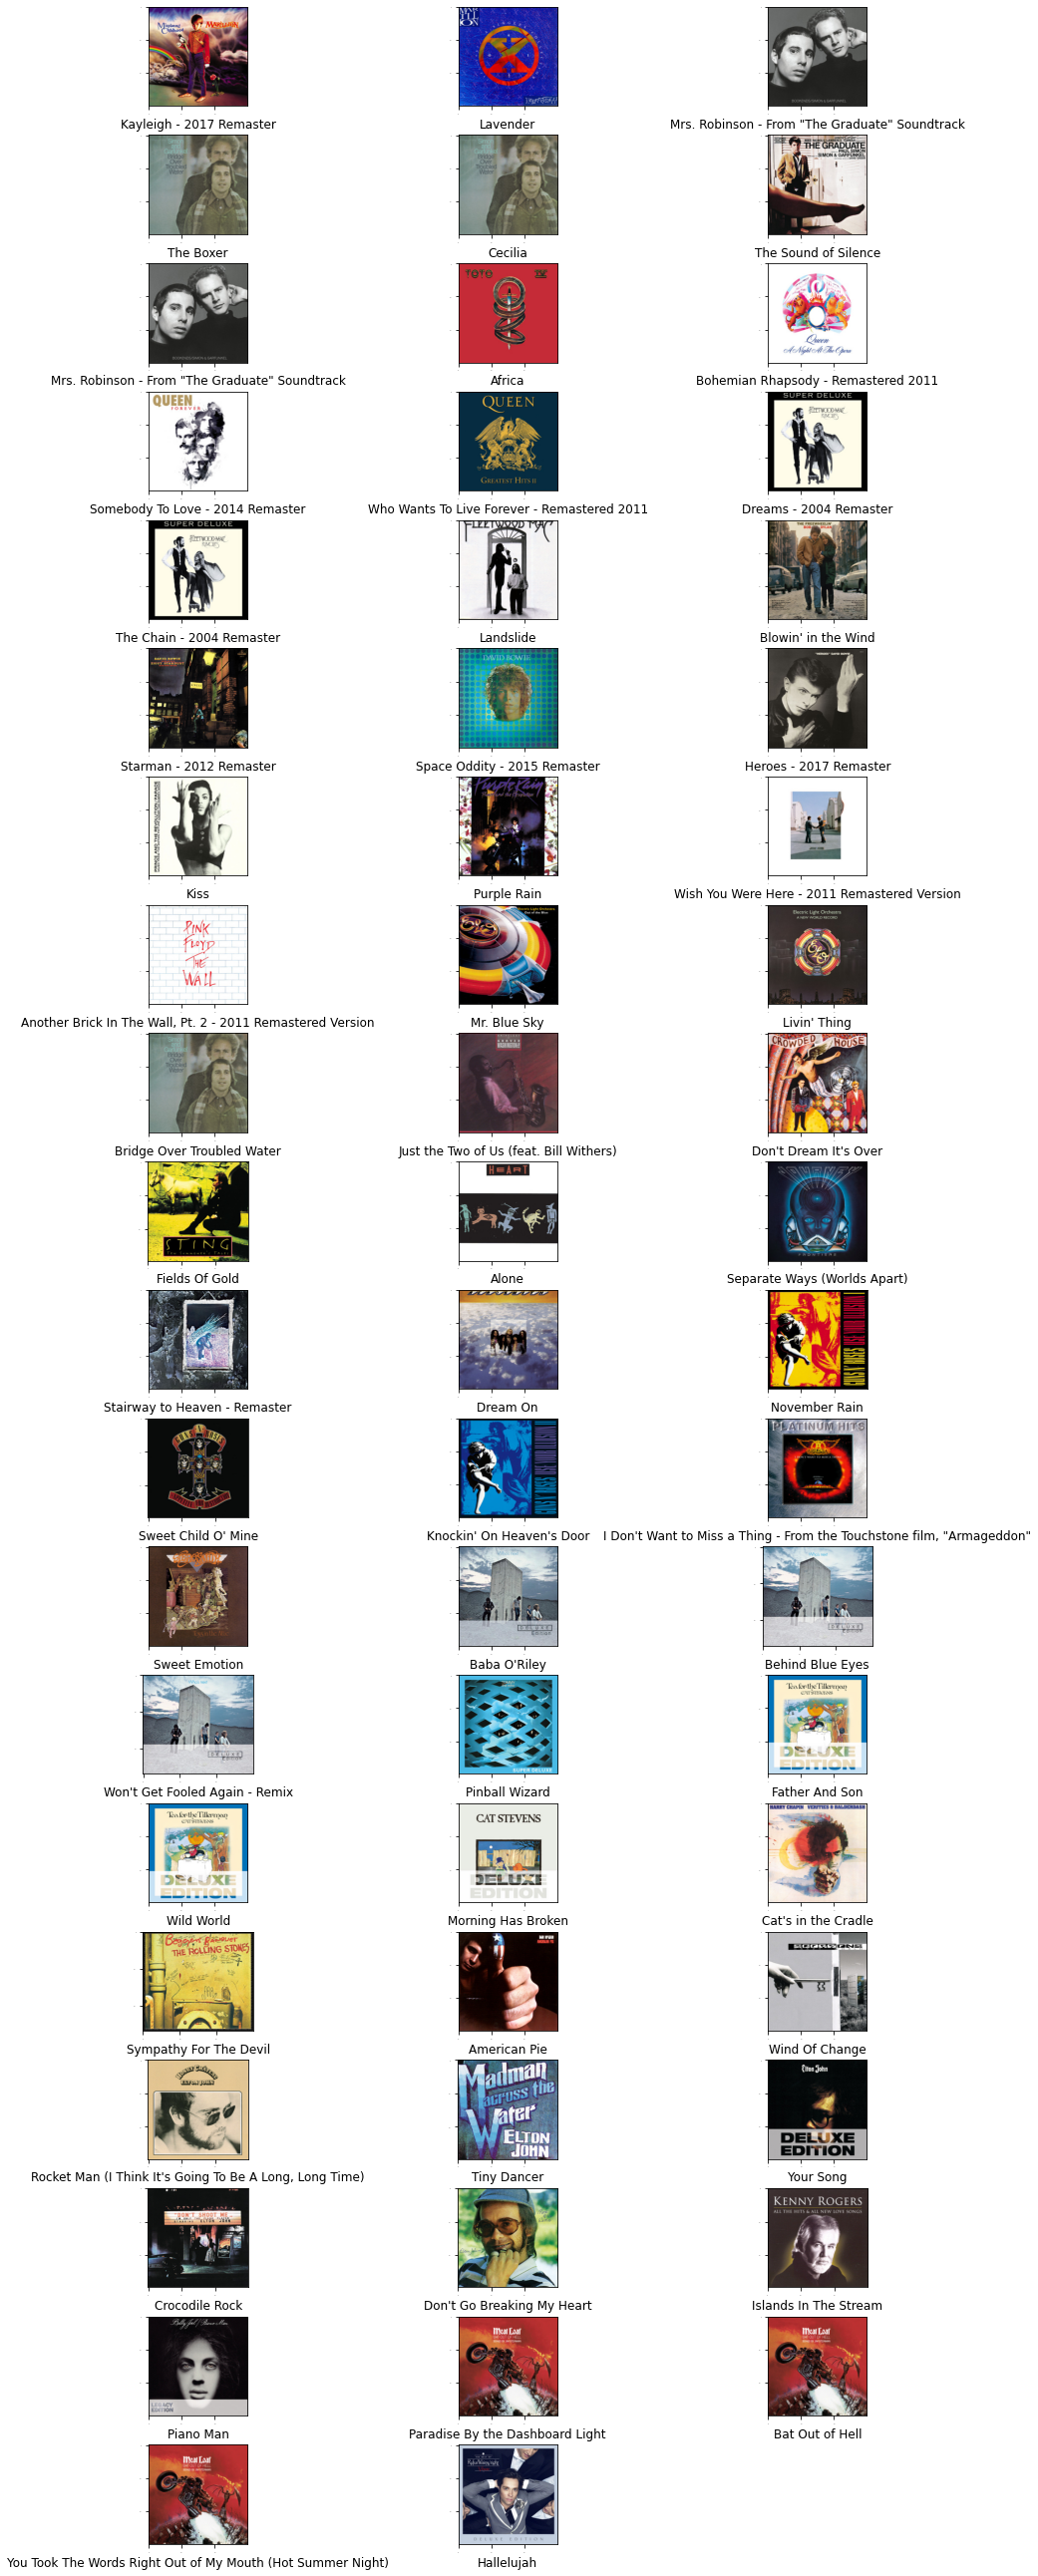

In [17]:
visualise_songs(df_playlist)

# Generating Recommendations

## Transforming Playlist

In [18]:
df_playlist_weight, df_non_playlist_feat = playlist_features(df_playlist=df_playlist, df_song_feat=df_song_feat, weight=1)

## Cosine Similarity

In [19]:
df_non_playlist_feat['song_similarity'] = cosine_similarity(df_non_playlist_feat.drop('id', axis = 1), df_playlist_weight)

## Top 5 Recommended

In [20]:
non_playlist_top_5 = df_non_playlist_feat.sort_values('song_similarity', ascending = False).head(5)

top_5 = pd.merge(
    non_playlist_top_5,
    df_song,
    on='id',
    how='inner'
).rename(columns={"name":"song_name"})

top_5['cover_url'] = top_5['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])

## Visualising Recommended

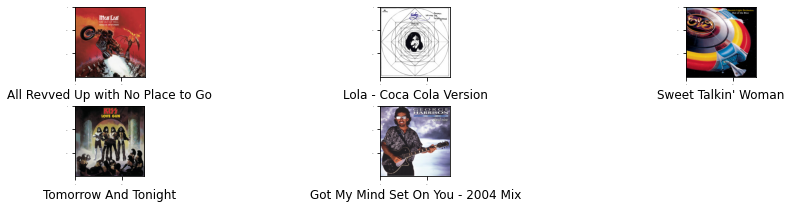

In [21]:
visualise_songs(top_5)

# Add Recommendations to Playlist

In [22]:
sp.user_playlist_add_tracks(SPOTIFY_USERNAME, PLAYLIST_ID, list(top_5['id']))

{'snapshot_id': 'NzUsZTE1ZjJlMTlkMDllNDg5MDliOTI4YWE4YjFjZGZkMGU0MzQ1ZTVkNg=='}